In [1]:
import gzip
import h5py
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, wilcoxon
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path += ["..", "../../predixcan_lite"]
import evaluation_utils
import utils

In [58]:
GEUVADIS_COUNTS_PATH = (
    "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
)
TRAIN_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/train.h5"

FUSION_WEIGHTS_DIR = "../../fusion/WEIGHTS"
FUSION_MODELS = ["top1", "lasso", "enet", "blup", "bslmm"]
FINETUNED_MODEL_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/ism"
BASELINE_MODEL_ISM_DIR = "../ISM/baseline.384_bins/"

FIGURES_DIR = "../figures"

In [4]:
counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")

gene_to_class_map = evaluation_utils.get_gene_to_class_map()
train_samples_per_gene = get_train_samples_per_gene()

# Helper functions

### Get samples per gene

In [5]:
def get_train_samples_per_gene() -> dict[str, set]:
    gene_to_samples = defaultdict(set)
    with h5py.File(TRAIN_H5_PATH, "r") as f:
        genes = f["genes"][:].astype(str)
        samples = f["samples"][:].astype(str)
        for (g, s) in zip(genes, samples):
            gene_to_samples[g].add(s)
    return gene_to_samples

### Extract common variants

In [7]:
def get_common_variants(
    genotype_mtx: pd.DataFrame, maf_threshold: float = 0.05
) -> tuple[list[Variant], pd.Series]:
    ac = genotype_mtx.applymap(utils.convert_to_dosage).sum(axis=1)
    an = genotype_mtx.applymap(utils.count_total_alleles).sum(axis=1)
    af = ac / an
    variants_f = af[(af >= maf_threshold) & (af <= 1 - maf_threshold)].index
    return variants_f.tolist(), af

### Load model weights

In [10]:
def load_fusion_weights(gene: str, model: str) -> pd.DataFrame:
    df = pd.read_csv(
        os.path.join(FUSION_WEIGHTS_DIR, f"{gene}.{model}.weights.txt"),
        sep="\t",
        header=None,
        names=["id", "alt", "ref", "weight"],
    )
    df["weight"] = df["weight"].astype(float)
    if df.isnull().values.any():
        weights_path = f"{gene}.{model}.weights.txt"
        print(f"WARNING: NaNs detected in {weights_path}")
        df = df.dropna()

    df["chrom"] = df["id"].apply(lambda x: x.split("_")[1])
    df["pos"] = df["id"].apply(lambda x: int(x.split("_")[2]))
    df["variant"] = [
        Variant(chrom, pos, ref, alt)
        for (chrom, pos, ref, alt) in zip(df["chrom"], df["pos"], df["ref"], df["alt"])
    ]
    df = df.set_index("variant")
    df = df[["weight"]]

    # We removed NaNs earlier, but let's make sure...
    assert df["weight"].notnull().all()
    assert df["weight"].apply(lambda x: isinstance(x, float)).all()
    return df


def load_enformer_model_isms(ism_dir: str, gene: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(ism_dir, f"{gene}.csv"), header=0, index_col=0)
    df.index = df.index.map(Variant.create_from_str)
    return df

### Compute variant importances

In [12]:
def compute_importance_percentiles(
    variants_df: pd.DataFrame,
    counts_df: pd.DataFrame,
    train_samples_per_gene: dict[str, str],
    context_size: int = 128 * 384,
) -> pd.DataFrame:
    """Adds {model}_beta, {model}_percentile, {model}_rank, n_training_variants, and training_af
    columns to variants_df.

        Parameters:
            variants_df: DataFrame with hg19_variant and our_gene_name columns
    """
    betas_per_model = defaultdict(list)
    normalized_betas_per_model = defaultdict(list)
    percentiles_per_model = defaultdict(list)
    ranks_per_model = defaultdict(list)
    causal_variant_afs = []
    n_training_variants = []

    # Caches
    common_variants_per_gene = {}
    afs_per_gene = {}
    n_training_variants_per_gene = {}

    for causal_variant, gene in tqdm(
        zip(variants_df["hg19_variant"], variants_df["our_gene_name"])
    ):
        if gene not in common_variants_per_gene:
            geno_mtx = utils.get_genotype_matrix(
                counts_df.loc[gene, "Chr"], counts_df.loc[gene, "Coord"], context_size
            )  # [variants, samples]
            # Get common variants within the training set
            train_samples = sorted(train_samples_per_gene[gene])
            geno_mtx = geno_mtx.loc[:, train_samples]
            common_variants_per_gene[gene], afs_per_gene[gene] = get_common_variants(
                geno_mtx
            )
            n_training_variants_per_gene[gene] = len(common_variants_per_gene[gene])

        common_variants = common_variants_per_gene[gene]
        causal_variant_afs.append(afs_per_gene[gene][causal_variant])
        n_training_variants.append(n_training_variants_per_gene[gene])

        # Get importance scores for FUSION models
        for model in FUSION_MODELS:
            weights = load_fusion_weights(gene, model)

            weights["importance"] = weights["weight"].abs()

            if model in ["blup", "bslmm"]:
                assert set(common_variants) == set(weights.index)
            else:
                assert set(weights.index).issubset(set(common_variants))

            # Hallucinate importances for variants not in the weights
            weights = weights.reindex(common_variants, fill_value=0.0)

            # Get the %ile of the the causal variant's importance relative to all importances of
            # training variants. If tied, assign the mean %ile of all tied variants.
            percentiles = weights["importance"].rank(pct=True, method="average") * 100.0
            ranks = weights["importance"].rank(method="average")
            betas_per_model[model].append(weights.loc[causal_variant, "weight"])
            normalized_betas_per_model[model].append(
                weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
            )
            percentiles_per_model[model].append(percentiles.loc[causal_variant])
            ranks_per_model[model].append(ranks.loc[causal_variant])

        # Get importance scores for Enformer models
        for model, ism_dir in [
            ("finetuned", FINETUNED_MODEL_ISM_DIR),
            ("baseline", BASELINE_MODEL_ISM_DIR),
        ]:
            isms = load_enformer_model_isms(ism_dir, gene)
            isms["importance"] = isms["ISM"].abs()
            assert set(common_variants).issubset(set(isms.index))
            isms = isms.loc[common_variants].copy()

            percentiles = isms["importance"].rank(pct=True, method="average") * 100.0
            ranks = isms["importance"].rank(method="average")
            betas_per_model[model].append(isms.loc[causal_variant, "ISM"])
            normalized_betas_per_model[model].append(
                isms.loc[causal_variant, "ISM"] / isms["ISM"].abs().max()
            )
            percentiles_per_model[model].append(percentiles.loc[causal_variant])
            ranks_per_model[model].append(ranks.loc[causal_variant])

    for model in FUSION_MODELS + ["finetuned", "baseline"]:
        variants_df[f"{model}_beta"] = betas_per_model[model]
        variants_df[f"{model}_normalized_beta"] = normalized_betas_per_model[model]
        variants_df[f"{model}_percentile"] = percentiles_per_model[model]
        variants_df[f"{model}_rank"] = ranks_per_model[model]
    variants_df["n_training_variants"] = n_training_variants
    variants_df["training_af"] = causal_variant_afs
    return variants_df

### Plotting code

In [76]:
model_renamings = {
    "baseline": "Baseline Enformer",
    "finetuned": "Fine-tuned Enformer",
    "top1": "Top SNP",
    "lasso": "LASSO",
    "enet": "Elastic net / PrediXcan",
    "blup": "BLUP",
    "bslmm": "BSLMM",
}


def plot_variant_identification_accuracy(
    results_df: pd.DataFrame,
    ax: plt.Axes,
    ylabel: str,
    title: str,
    eqtls: bool = True,
    legend: bool = True,
    max_top_percentile_threshold: int = 25,
):
    top_percentile_thresholds = np.arange(1, max_top_percentile_threshold + 1)
    for model in model_renamings:
        percentiles = results_df[f"{model}_percentile"].values
        accs = [np.mean(percentiles >= 100 - t) for t in top_percentile_thresholds]
        ax.plot(
            top_percentile_thresholds,
            accs,
            "-o",
            markersize=3,
            label=model_renamings[model],
        )

    n_variants = len(results_df)
    n_genes = results_df["our_gene_name"].nunique()
    if eqtls:
        title += f"\n({n_variants} eQTLs, {n_genes} eGenes)"
    else:
        title += f"\n({n_variants} variants, {n_genes} genes)"

    ax.set(xlabel="Top percentile threshold", ylabel=ylabel, title=title)
    if legend:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    else:
        ax.legend().set_visible(False)


def plot_mean_importance_per_gene(
    results_df: pd.DataFrame,
    ax: plt.Axes,
    ylabel: str,
    title: str,
):
    models, genes, mean_importances = [], [], []
    for gene in results_df["our_gene_name"].unique():
        gene_subset_df = results_df[results_df["our_gene_name"] == gene]
        for model in model_renamings:
            mean_importances.append(gene_subset_df[f"{model}_percentile"].mean())
            models.append(model_renamings[model])
            genes.append(gene)

    plot_df = pd.DataFrame(
        {"model": models, "gene": genes, "mean_importance": mean_importances}
    )
    sns.boxplot(x="model", y="mean_importance", data=plot_df, ax=ax)
    sns.stripplot(
        x="model", y="mean_importance", data=plot_df, ax=ax, color=".25", alpha=0.5
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    n_egenes = results_df["our_gene_name"].nunique()
    ax.set(
        xlabel="",
        ylabel="Mean importance percentile of shared eQTLs",
        title=title + "\n" + f"(n = {n_egenes} eGenes)",
    )

# MAGE

In [13]:
MAGE_RES_PATH = (
    "MAGE/eQTL_finemapping.significantAssociations.trainingVariants.MAGE.v1.0.hg19.txt"
)

In [14]:
mage_df = pd.read_csv(MAGE_RES_PATH, sep="\t")
mage_df = mage_df[mage_df["variantPIP"] > 0.9].copy()
mage_df["hg19_variant"] = mage_df["hg19_variant"].apply(Variant.create_from_str)

In [15]:
mage_df = compute_importance_percentiles(mage_df, counts_df, train_samples_per_gene)

0it [00:00, ?it/s]

/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()


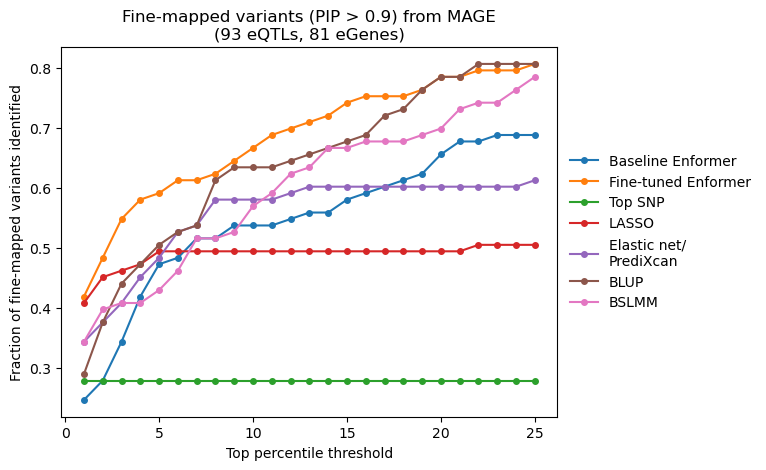

In [16]:
fig, ax = plt.subplots()
plot_variant_identification_accuracy(
    mage_df,
    ax,
    "Fraction of fine-mapped variants identified",
    "Fine-mapped variants (PIP > 0.9) from MAGE",
)
plt.show()

## eQTLs shared between Europeans and Yorubans

In [42]:
SHARED_EQTLS_PATH = "ancestry_shared_eqtls/shared_training_eqtls.tsv"

In [50]:
shared_eqtls_df = pd.read_csv(SHARED_EQTLS_PATH, sep="\t")
shared_eqtls_df["gene_class"] = shared_eqtls_df["our_gene_name"].map(gene_to_class_map)
shared_eqtls_df["hg19_variant"] = shared_eqtls_df["hg19_variant"].apply(
    Variant.create_from_str
)

shared_eqtls_df = compute_importance_percentiles(
    shared_eqtls_df, counts_df, train_samples_per_gene
)

0it [00:00, ?it/s]

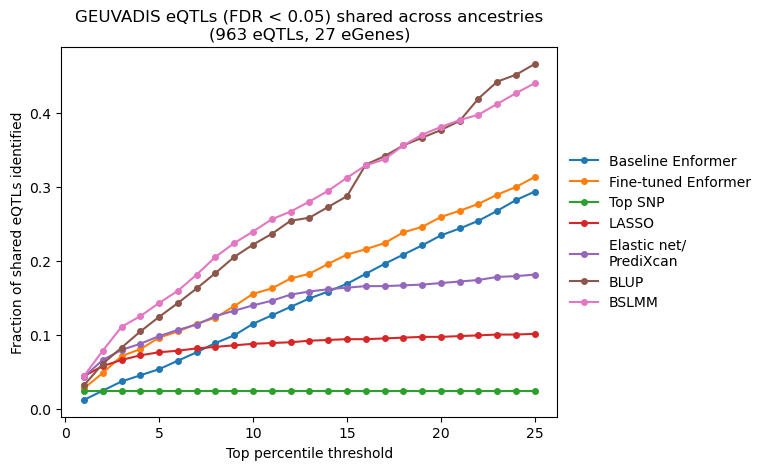

In [74]:
fig, ax = plt.subplots()
plot_model_accuracies(
    shared_eqtls_df,
    ax,
    "Fraction of shared eQTLs identified",
    "GEUVADIS eQTLs (FDR < 0.05) shared across ancestries",
)
plt.show()

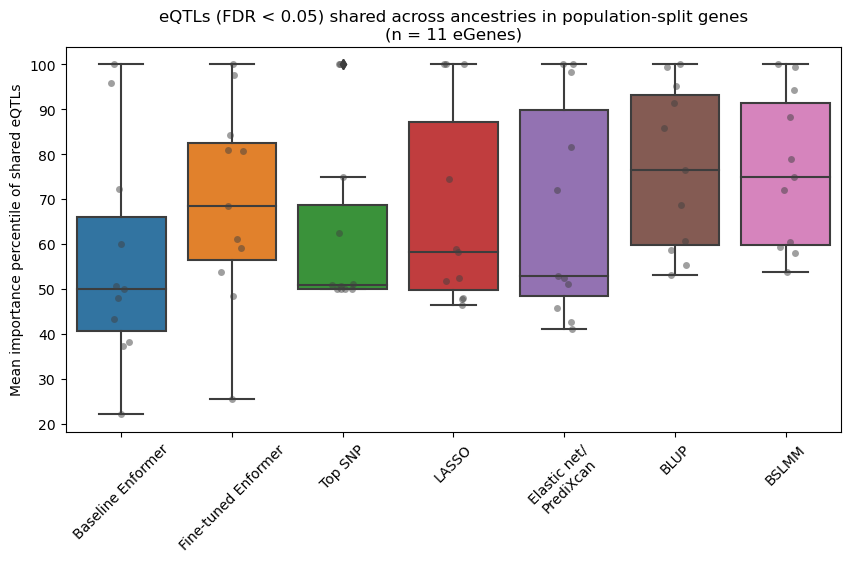

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_mean_importance_per_gene(
    shared_eqtls_df[shared_eqtls_df["gene_class"] == "yri_split"],
    ax,
    "Mean importance percentile",
    "eQTLs (FDR < 0.05) shared across ancestries in population-split genes",
)
plt.show()

# MPRA

In [17]:
MPRA_PATH = "Malinois_MPRA/GM12878_effect_sizes.trainingVariants.csv"

In [18]:
mpra_df = pd.read_csv(MPRA_PATH)
mpra_df["hg19_variant"] = mpra_df["hg19_variant"].apply(Variant.create_from_str)
mpra_df = mpra_df[mpra_df["GM12878_Skew_FDR"] < 0.25].copy()
mpra_df = compute_importance_percentiles(mpra_df, counts_df, train_samples_per_gene)

0it [00:00, ?it/s]

/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()


/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()
/tmp/ipykernel_3481996/1450526487.py:60: RuntimeWarning: invalid value encountered in scalar divide
  weights.loc[causal_variant, "weight"] / weights["weight"].abs().max()


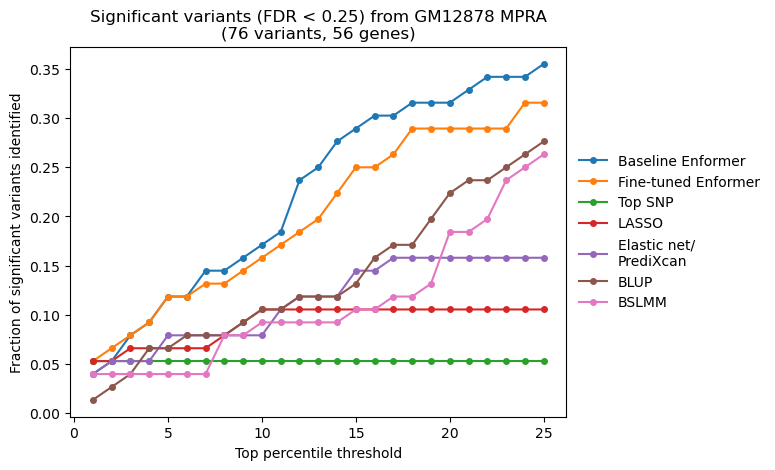

In [19]:
fig, ax = plt.subplots()
plot_variant_identification_accuracy(
    mpra_df,
    ax,
    "Fraction of significant variants identified",
    "Significant variants (FDR < 0.25) from GM12878 MPRA",
    eqtls=False,
)
plt.show()

In [84]:
# How many unique variant-gene pairs are there compared to MAGE dataset?
mpra_pairs = set(zip(mpra_df["hg19_variant"], mpra_df["our_gene_name"]))
mage_pairs = set(zip(mage_df["hg19_variant"], mage_df["our_gene_name"]))
n_unique = len(mpra_pairs - mage_pairs)
print(
    f"MPRA dataset has {n_unique}/{len(mpra_pairs)} unique variant-gene pairs compared to MAGE dataset"
)

MPRA dataset has 74/76 unique variant-gene pairs compared to MAGE dataset


In [20]:
def plot_variant_directional_concordance(
    variants_df: pd.DataFrame,
    ax: plt.Axes,
    title: str,
):
    models = []
    model_concordances = []
    for model in model_renamings:
        # Compute the concordance between the sign of the effect size and the sign of the beta
        # For variants that were not selected (beta = 0), we assume the concordance is 0.5
        betas = variants_df[f"{model}_beta"].values
        es = variants_df["GM12878_normalized_variant_effect"].values
        mask = betas != 0.0

        scored_concordances = np.sign(betas[mask]) == np.sign(es[mask])
        unscored_concordances = np.full_like(betas[~mask], 0.5)
        all_concordances = np.concatenate((scored_concordances, unscored_concordances))

        models.append(model_renamings[model])
        model_concordances.append(np.mean(all_concordances))

    ax.bar(models, model_concordances)
    ax.axhline(0.5, color="black", linestyle="--")
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)
    ax.set(
        ylabel="Fraction of variants whose"
        + "\n"
        + "predicted effect direction matches MPRA",
        title=title,
    )
    plt.show()

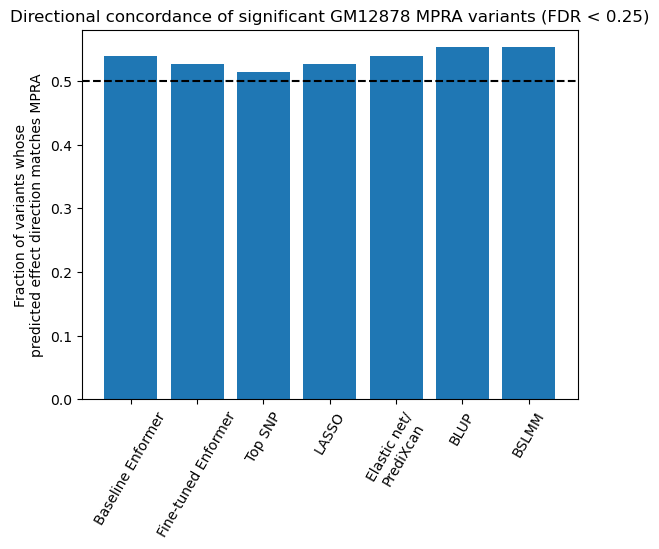

In [21]:
fig, ax = plt.subplots()
plot_variant_directional_concordance(
    mpra_df,
    ax,
    "Directional concordance of significant GM12878 MPRA variants (FDR < 0.25)",
)
plt.show()

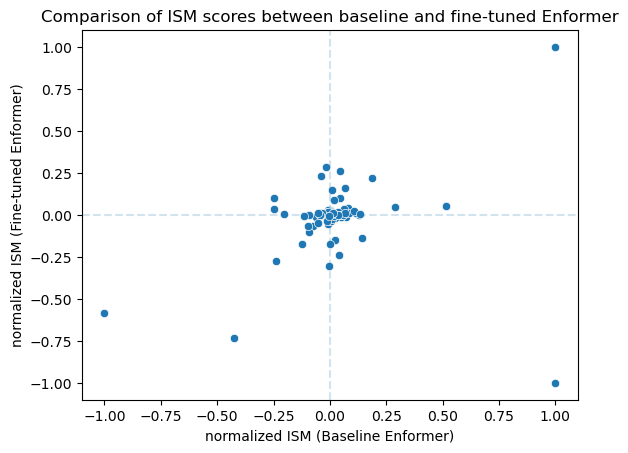

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=mpra_df, x="baseline_normalized_beta", y="finetuned_normalized_beta", ax=ax
)
ax.axhline(0.0, ls="--", alpha=0.2)
ax.axvline(0.0, ls="--", alpha=0.2)
ax.set(
    xlabel=r"normalized ISM (Baseline Enformer)",
    ylabel=r"normalized ISM (Fine-tuned Enformer)",
    title="Comparison of ISM scores between baseline and fine-tuned Enformer",
)
plt.show()

# Full figure

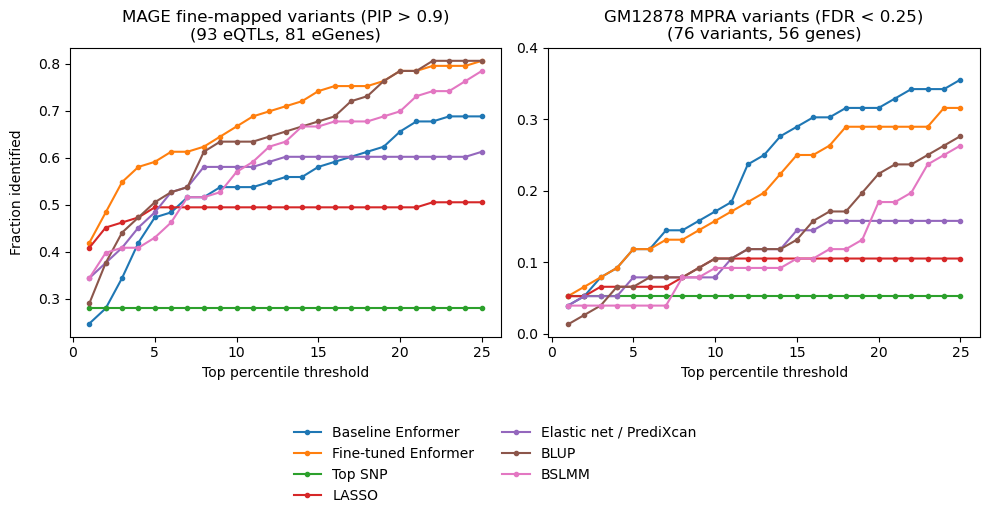

In [77]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True)

plot_variant_identification_accuracy(
    mage_df,
    axs[0],
    ylabel="Fraction identified",
    title="MAGE fine-mapped variants (PIP > 0.9)",
    legend=False,
)
axs[0].set_ylabel("Fraction identified", labelpad=10)

plot_variant_identification_accuracy(
    mpra_df,
    axs[1],
    ylabel="",
    title="GM12878 MPRA variants (FDR < 0.25)",
    eqtls=False,
    legend=False,
)
# Set yticks for axs[1] to only have one decimal place
ymin, ymax = axs[1].get_ylim()
yticks = np.arange(0.0, ymax + 0.1, 0.1)
axs[1].set_yticks(yticks)

# Move the legend to be underneath both subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    frameon=False,
    ncol=2,
)

plt.savefig(
    os.path.join(FIGURES_DIR, "causal_variant_identification.pdf"), bbox_inches="tight"
)

plt.tight_layout()
plt.show()